In [1]:
import pandas as pd

In [2]:
import snowflake.connector as sf

In [3]:
from snowflake.connector import DictCursor

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from pprint import pprint
import re

# gensim (LDA)
from gensim import corpora, models
from gensim.utils import simple_preprocess as gusp
from gensim.models import CoherenceModel
from gensim.models import Phrases as gmp
from gensim.models import phrases as gmpp
from gensim.models import ldamodel as lda

#spacy for lemmatization
import spacy

Get WP Posts from Snowflake
=================
Query pulls 5000 of the most recent published posts and their content from the Migraine Community

In [6]:

#plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#snowflake connector
#import credentials 
import credentials
ctx = sf.connect(
user='abratun',
password='bfr*nfx0wga1RYH7eup',
account='yq01973.us-east-1'
)
cs = ctx.cursor(DictCursor)

#set database 
cs.execute('USE DATABASE HU_DATA')

#create query
cs.execute("""
            SELECT distinct post_content || 'post_id: ' || post_id as post_content
                , post_id || '_' || site_prefix post_id
            FROM prod."posts"
            WHERE post_status = 'publish' and post_type = 'post'
            and site_prefix = 'WP'
            ORDER BY POST_ID DESC
            LIMIT 5000
            """)
            
#change into rows 
data = [row for row in cs]

#make dataframe
sql=pd.DataFrame(data)
#sql.head()

cs.close()

True

Cleaning Post Text
==================

First, we remove all the links and HTML in the post content:
------------

In [7]:
dfList_rough = sql['POST_CONTENT'].tolist()

from bs4 import BeautifulSoup
def cleanhtml(texts):
    results = []
    for doc in texts:
        cleantext=BeautifulSoup(doc, "html.parser").text
        results.append(cleantext)
    return results

dfList_html = cleanhtml(dfList_rough)

Then we remove the leadgen code at the end of the post.
-------

In [9]:
def remove_between_square_brackets(texts):
    results = []
    for doc in texts:
        cleantext=re.sub('\[[^]]*\]', '', doc)
        results.append(cleantext)
    return results

dfList = remove_between_square_brackets(dfList_html)

Removing Stopwords
================
Because we're going to be looking at descriptive words to determine the topics, we want to get rid of common english words that might bias the LDA's topic creations.  [This](https://gist.github.com/sebleier/554280) is a list of the stopwords currently included in the NLTK package. 

We are also removing 'migraine' from consideration as most posts will have it in the content somewhere, so including it in the LDA will cause most topics to contain the word, which weakens the coherence of the topics. 

In [10]:
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
migraine_stopwords=['migraine', 'migraines', 'post_content', 'post_id']
stop_words.extend(migraine_stopwords)

def sent_to_words(sentences):
        for sentence in sentences:
            yield(gusp(str(sentence), deacc=True))
            #deacc removes punctuations
data_words = list(sent_to_words(dfList))


Bigrams & Trigrams
========
### Bi-grams and tri-grams allow us to combine two (bi) or three (tri) words that commonly appear together.



In [11]:
#build the models 
bigram=gmp(data_words, min_count=5, threshold=100)
#higher threshold = fewer phrases
trigram=gmp(bigram[data_words], threshold=100)

#faster way to get a sentence clubbed as trigram/bigram
bigram_mod=gmpp.Phraser(bigram)
trigram_mod=gmpp.Phraser(trigram)


#print(trigram_mod[bigram_mod[data_words[0]]])

##remove stopwords, make bigrams and lemmatize

#define functions for stopwords, bigrams, trigrams, & lemmatization
def remove_stopwords(texts):
    return[[word for word in gusp(str(doc)) if word not in stop_words] for doc in texts]
    
def make_bigrams(texts):
    return[bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return[trigram_mod[bigram_mod[doc]] for doc in texts]
    
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

##call functions in order

#remove stop words
data_words_nostops=remove_stopwords(data_words)

#form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [13]:
#initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#lemmatization - keep only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams)

##create dictionary and corpus needed for LDA
#dictionary
id2word = corpora.Dictionary(data_lemmatized)

#corpus
texts = data_lemmatized

#term doc frequency
corpus = [id2word.doc2bow(text) for text in texts]

#shows word frequency in document
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


In [14]:
#build topic model
#LDA model
lda_model = lda.LdaModel(corpus=corpus, id2word=id2word, num_topics=26, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

#print keyword in 10 topics
#pprint(lda_model.print_topics())
doc_lda=lda_model[corpus]

In [15]:
#type(lda_model)

In [16]:
##compute perplexity and coherence
#perplexity - the lower the better -7.352 (-7.56 after removing HTML and [] content)
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#coherence score 0.421 (.379 after removing HTML and [] content)
# 26 topics = 0.477
# 20 topics = 0.450
coherence_model_lda=CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)



Perplexity:  -11.534550745379143

Coherence Score: 0.44887320743125225


In [17]:
#visualize LDA
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/abratun/Repos/KeywordExtraction/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.274339 -0.165768       1        1  30.518099
11     0.294469  0.011747       2        1  14.107018
19     0.274778  0.144833       3        1  10.595768
8      0.261236  0.013748       4        1   8.740528
5      0.155720 -0.307408       5        1   6.518875
23     0.194197  0.226510       6        1   4.717422
16     0.177382 -0.138997       7        1   4.233165
17     0.147738  0.141479       8        1   3.852866
2      0.139215 -0.010441       9        1   3.274023
20     0.102133  0.132606      10        1   2.795762
3      0.022499 -0.188002      11        1   1.738103
25     0.048501  0.049130      12        1   1.669358
18     0.032880  0.074156      13        1   1.233701
12    -0.052443 -0.012401      14        1   1.091656
6     -0.094164 -0.018221      15        1   1.010644
15    -0.111537  0.022343      16        1   0.792339
7     -0.116391  0.014372      17        1   0.733103
21    -0.119873  0.006524      18        1   0.676450
9     -0.145971 -0.050248      19        1   0.533175
24    -0.160548  0.012507      20        1   0.293808
1     -0.201102 -0.000284      21        1   0.243686
14    -0.215109  0.011776      22        1   0.234544
22    -0.205349  0.010391      23        1   0.221562
13    -0.223378  0.009462      24        1   0.145310
0     -0.238507  0.005689      25        1   0.026186
4     -0.240714  0.004496      26        1   0.002847, topic_info=             Term         Freq        Total Category  logprob  loglift
475    medication  4746.000000  4746.000000  Default  30.0000  30.0000
124          pain  9864.000000  9864.000000  Default  29.0000  29.0000
400          work  3107.000000  3107.000000  Default  28.0000  28.0000
707        doctor  4625.000000  4625.000000  Default  27.0000  27.0000
188       trigger  2976.000000  2976.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
24   bright_light     0.000924    93.319351  Topic26  -9.8841  -1.0564
25        brother     0.000924    78.298846  Topic26  -9.8841  -0.8810
27           calm     0.000924   216.048678  Topic26  -9.8841  -1.8959
28            car     0.000924   541.738328  Topic26  -9.8841  -2.8152
29      caretaker     0.000924   349.673395  Topic26  -9.8841  -2.3774

[1341 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3589     17  0.924649  abdoman
1268      2  0.851244  ability
1268      3  0.048314  ability
1268      7  0.096628  ability
0         1  0.811284     able
...     ...       ...      ...
198       2  0.153068    young
198       4  0.089486    young
198       5  0.680565    young
198      12  0.058872    young
198      18  0.014129    young

[2022 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 20, 9, 6, 24, 17, 18, 3, 21, 4, 26, 19, 13, 7, 16, 8, 22, 10, 25, 2, 15, 23, 14, 1, 5])

In [18]:
# # LDA Mallet Model
import gensim

In [20]:
mallet_path = 'mallet-2.0.8/bin/mallet'

In [21]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=32, id2word=id2word)

Mallet LDA: 32 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 875
total tokens: 542840
<10> LL/token: -10,03106
<20> LL/token: -9,13206
<30> LL/token: -8,79466
<40> LL/token: -8,6247

0	1,5625	time year stress back exercise long week day pregnancy routine schedule life hope good walk frequency pattern sister healthy regular 
1	1,5625	study patient treatment research result participant researcher group people trial episodic clinical_trial chronic frequency survey datum percent reduction therapy impact 
2	1,5625	light dog time movie favorite comfort place eye window side dark cat game sun family quiet world clean room pet 
3	1,5625	research headache story disease community share event year people awareness member group support article advocate online patient foundation advocacy video 
4	1,5625	thing good day cold room summer hot time bed cool heat air comfortable lot head place temperature long kind item 
5	1,5625	trigger food diet list holiday meal caffeine healthy free

<110> LL/token: -8,35058
<120> LL/token: -8,33763
<130> LL/token: -8,33194
<140> LL/token: -8,32773

0	1,5625	time stress exercise good healthy year schedule back health routine change week regular long pattern thing day habit walk hard 
1	1,5625	study patient treatment result research researcher participant group trial episodic clinical_trial people frequency chronic survey percent datum impact placebo finding 
2	1,5625	light dog smell bright room home dark world place favorite noise sun sense comfort bad sensitive window scent cat quiet 
3	1,5625	research story disease community year event share headache awareness group online member support advocate foundation website video advocacy organization national 
4	1,5625	cold head time thing hot day summer good store lot cool heat bed room temperature ice bit warm full comfortable 
5	1,5625	food trigger diet list free caffeine meal alcohol drink good sugar histamine easy ingredient chocolate healthy high chemical recipe fruit 
6	1,5625	sym

<210> LL/token: -8,30518
<220> LL/token: -8,29991
<230> LL/token: -8,29788
<240> LL/token: -8,29663

0	1,5625	time stress exercise good healthy schedule year back health routine plan thing long regular change week habit hard walk day 
1	1,5625	study patient research result treatment researcher participant trial group clinical_trial people episodic survey frequency datum chronic percent placebo impact number 
2	1,5625	light dog room smell bright bad dark glass eye noise sensitive sound home place window sense sun scent cat screen 
3	1,5625	research story community disease event year group share member awareness online support advocate foundation information organization headache video advocacy website 
4	1,5625	cold head hot good lot bed summer thing heat long cool temperature ice day comfortable warm neck pack hour bit 
5	1,5625	food trigger diet free list meal caffeine alcohol drink sugar histamine good high water chocolate ingredient chemical recipe fruit easy 
6	1,5625	symptom pain 

<310> LL/token: -8,29218
<320> LL/token: -8,29007
<330> LL/token: -8,29057
<340> LL/token: -8,29077

0	1,5625	time stress good exercise thing healthy schedule plan routine back health long regular habit hard activity break change walk goal 
1	1,5625	study patient treatment result research participant trial group researcher clinical_trial device episodic frequency survey datum chronic placebo percent number impact 
2	1,5625	light dog glass eye room smell bright sound dark noise window sensitive thing sense cat scent screen loud world sun 
3	1,5625	research story disease community event year group awareness share member support advocate website foundation organization online information advocacy national opportunity 
4	1,5625	cold head bed hot time lot summer cool long good heat thing neck ice temperature day warm comfortable case pack 
5	1,5625	food trigger diet list meal free drink caffeine alcohol water histamine sugar easy lot chocolate ingredient recipe good fruit high 
6	1,5625	sym

<410> LL/token: -8,29145
<420> LL/token: -8,29198
<430> LL/token: -8,29075
<440> LL/token: -8,2936

0	1,5625	time stress exercise good thing healthy health schedule plan routine day year regular back long habit hard break change important 
1	1,5625	study patient research result treatment participant trial group researcher device episodic frequency clinical_trial survey chronic datum percent month high number 
2	1,5625	light dog eye glass bright smell room sensitive noise home loud sound window dark sense scent cat screen sunglass place 
3	1,5625	research disease year event community support group headache awareness patient member advocate foundation story information advocacy online national mile organization 
4	1,5625	cold head water hot time summer bed thing lot neck cool heat long day ice temperature warm good comfortable case 
5	1,5625	food trigger diet drink free list caffeine water meal alcohol sugar histamine good ingredient chocolate easy recipe fruit high chemical 
6	1,5625	sy

<510> LL/token: -8,2912
<520> LL/token: -8,29164
<530> LL/token: -8,28957
<540> LL/token: -8,29255

0	1,5625	time stress exercise good thing healthy plan schedule routine health year long habit regular work change day break hard activity 
1	1,5625	study patient research result participant group treatment researcher device trial episodic clinical_trial survey frequency datum chronic percent impact number people 
2	1,5625	light dog glass eye smell bright sensitive room sound window dark scent cat noise screen sense comfort world home loud 
3	1,5625	research disease year event headache group support awareness community patient advocate member organization foundation advocacy national information mile public challenge 
4	1,5625	water cold head hot time lot bed heat summer thing day cool neck ice temperature good warm relief comfortable case 
5	1,5625	food trigger diet list drink free water caffeine meal good sugar histamine alcohol easy ingredient chocolate healthy recipe fruit chemical 
6

<610> LL/token: -8,29492
<620> LL/token: -8,29607
<630> LL/token: -8,29405
<640> LL/token: -8,29489

0	1,5625	time good stress exercise thing healthy plan day schedule hard routine health year regular habit rest break work change daily 
1	1,5625	study patient research result treatment participant researcher group trial device episodic frequency people clinical_trial chronic datum number impact month finding 
2	1,5625	light dog glass eye smell bright sensitive dark noise room sense window sound cat loud sunglass screen scent night thing 
3	1,5625	research disease year event headache group awareness support patient community advocate organization member foundation advocacy national mile education opportunity funding 
4	1,5625	water cold hot head time lot neck summer heat bed cool thing relief ice good day warm temperature body comfort 
5	1,5625	food trigger diet list meal free drink caffeine water sugar histamine alcohol good ingredient chocolate body easy chemical recipe fruit 
6	1,5625

<710> LL/token: -8,29488
<720> LL/token: -8,29406
<730> LL/token: -8,29347
<740> LL/token: -8,29641

0	1,5625	time good exercise stress thing healthy plan schedule year hard routine health week day rest habit regular break work goal 
1	1,5625	study patient research result participant researcher group treatment device trial episodic frequency clinical_trial chronic datum people month number percent impact 
2	1,5625	light dog eye glass smell bright sensitive dark noise window sound room loud sense sunglass cat screen world scent home 
3	1,5625	research disease event headache year patient support awareness group advocate community foundation member organization advocacy national mile challenge public american 
4	1,5625	water cold head hot neck lot thing time summer heat cool body bed ice temperature warm relief day comfortable long 
5	1,5625	food trigger diet free list caffeine meal sugar drink histamine water body easy good alcohol chocolate ingredient recipe high fruit 
6	1,5625	symptom

<810> LL/token: -8,28907
<820> LL/token: -8,29239
<830> LL/token: -8,29431
<840> LL/token: -8,29274

0	1,5625	time exercise good healthy plan thing year schedule day health hard routine week long habit rest goal daily break regular 
1	1,5625	study patient research result participant group researcher treatment device trial episodic chronic frequency clinical_trial datum people month number high impact 
2	1,5625	light dog glass eye smell bright sensitive room dark sound noise window scent cat sunglass screen thing sense loud good 
3	1,5625	research disease headache event year patient group awareness advocate community foundation organization advocacy national member support mile challenge public education 
4	1,5625	water cold head hot neck lot heat summer thing cool time temperature ice warm bed pressure body skin pack shoulder 
5	1,5625	food trigger diet caffeine list meal free drink sugar alcohol histamine water easy ingredient good chocolate high healthy recipe chemical 
6	1,5625	symp

<910> LL/token: -8,29276
<920> LL/token: -8,29125
<930> LL/token: -8,29615
<940> LL/token: -8,28939

0	1,5625	time good exercise day plan healthy schedule thing year hard week health routine long break change habit goal regular rest 
1	1,5625	study patient result research participant researcher group treatment device trial episodic frequency clinical_trial chronic datum number impact people month percent 
2	1,5625	light dog eye glass smell bright dark room sensitive sound noise loud window scent sun screen sunglass cat sense comfort 
3	1,5625	research disease headache year event group patient awareness advocate foundation community advocacy support organization national member mile opportunity challenge race 
4	1,5625	water cold neck head hot body summer thing cool lot heat bed temperature ice warm time pack relief pressure shoulder 
5	1,5625	food trigger diet list free meal caffeine easy sugar histamine alcohol drink good ingredient chocolate chemical high recipe lot oil 
6	1,5625	sym

In [22]:
coherence_model_mallet=CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_mallet=coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Coherence Score: 0.44887320743125225


/Users/abratun/Repos/KeywordExtraction/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abratun/Repos/KeywordExtraction/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abratun/Repos/KeywordExtraction/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abratun/Repos/KeywordExtraction/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/a

In [23]:
#show topics
#pprint(ldamallet.show_topics())

In [24]:
#compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

In [25]:
 coherence_ldamallet = coherence_model_ldamallet.get_coherence()

In [26]:
 print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5041820527046649


In [27]:
# #optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [28]:
 model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 875
total tokens: 542840
<10> LL/token: -8,44336
<20> LL/token: -8,1621
<30> LL/token: -8,03296
<40> LL/token: -7,99199

0	25	time day life pain thing good trigger attack work friend year bad back long head lot food week family home 
1	25	headache treatment patient pain medication people doctor symptom attack chronic disease study health condition drug research year care month information 

<50> LL/token: -7,97381
<60> LL/token: -7,96272
<70> LL/token: -7,95653
<80> LL/token: -7,95241
<90> LL/token: -7,95101

0	25	time day life thing pain good trigger attack work year friend bad back long head lot family food week home 
1	25	headache treatment patient pain medication doctor people symptom attack chronic disease study health condition drug research year month care information 

<100> LL/token: -7,94636
<110> LL/token: -7,94644
<120> LL/token: -7,94242
<130> LL/token: -7,94087
<140> LL/token: -7,9428

0	25	time day

<10> LL/token: -9,43175
<20> LL/token: -8,80946
<30> LL/token: -8,51895
<40> LL/token: -8,38046

0	6,25	day time food trigger friend thing good back year husband list long lot book week free home love hour family 
1	6,25	life people chronic pain family thing child illness person experience time friend disease hard good year relationship world care support 
2	6,25	health year information work condition event part time job story community issue disability care people online post person state member 
3	6,25	time day body sleep stress week work pain good bad hour back bed long exercise thing morning trigger night head 
4	6,25	attack pain symptom people woman headache study trigger aura cluster high severe common experience risk heart frequency episodic change year 
5	6,25	head pain light eye bad home room time cold hand car place side thing back neck long face water dog 
6	6,25	medication treatment doctor drug patient study option month side_effect prescription medicine insurance relief ef

<360> LL/token: -8,12488
<370> LL/token: -8,12631
<380> LL/token: -8,12572
<390> LL/token: -8,12727

0	6,25	trigger food friend good time list book family free year great day thing love lot kid plan diet easy weather 
1	6,25	life people chronic pain thing person family friend illness experience disease good time world hard relationship child care feeling difficult 
2	6,25	health information care story people community condition year share issue event online disability time part article post state medical office 
3	6,25	day time week work year back stress sleep good long body hour bad thing month bed exercise hard morning night 
4	6,25	pain attack symptom woman experience headache severe people aura cluster body head heart migraineur change brain common low nausea level 
5	6,25	head light eye home room time back water cold thing car hand place minute house face dog night bad long 
6	6,25	medication treatment doctor drug month option side_effect medicine prescription relief effective pre

<710> LL/token: -8,13368
<720> LL/token: -8,13448
<730> LL/token: -8,13485
<740> LL/token: -8,13337

0	6,25	trigger food good friend time list book great lot free kid family love diet year day easy weather healthy tip 
1	6,25	life people chronic friend thing family person illness pain time disease world experience good hard child care relationship hope support 
2	6,25	health information care story people community condition year event issue share disability online time part state insurance medical post person 
3	6,25	day time week work year good back sleep thing long hour bad month stress body bed hard exercise morning lot 
4	6,25	pain attack symptom headache experience severe people head body cluster change brain heart aura migraineur woman part side common neck 
5	6,25	head light home room time eye thing back hand cold car house water place minute long dog bad night glass 
6	6,25	medication treatment doctor drug month medicine option side_effect patient prescription relief effective 

<60> LL/token: -8,33218
<70> LL/token: -8,3017
<80> LL/token: -8,27774
<90> LL/token: -8,26247

0	3,57143	attack brain migraineur symptom body change woman aura experience disease problem type part level issue period case man system hormone 
1	3,57143	patient study treatment result people research risk researcher chronic heart participant group episodic device trial high frequency clinical_trial history woman 
2	3,57143	doctor health patient care medical specialist insurance appointment plan disability surgery program option office cost treatment condition benefit hospital information 
3	3,57143	medication treatment drug doctor side_effect medicine therapy option prescription effective relief preventive dose injection abortive pill month triptan product cgrp 
4	3,57143	day time work week year month bad long back job good finally hour hope thing hard free full lot due 
5	3,57143	pain headache attack symptom diagnosis cluster disorder head severe relief experience treatment neck cluster_

<260> LL/token: -8,19487
<270> LL/token: -8,19505
<280> LL/token: -8,19409
<290> LL/token: -8,1922

0	3,57143	attack symptom brain migraineur body change experience woman aura disease type problem fatigue part common level sign normal frequent case 
1	3,57143	patient study treatment result research risk researcher people chronic participant heart group surgery device trial high episodic frequency test clinical_trial 
2	3,57143	doctor health care patient medical specialist insurance appointment plan visit disability option program treatment cost office condition state issue provider 
3	3,57143	medication treatment drug doctor side_effect medicine therapy option effective relief prescription dose injection preventive abortive month pill triptan effect cgrp 
4	3,57143	day time work week year month bad long back finally job hour thing full good free hope hard home med 
5	3,57143	pain headache attack head diagnosis cluster disorder treatment severe relief neck symptom chronic cluster_headac

<460> LL/token: -8,19106
<470> LL/token: -8,19428
<480> LL/token: -8,19327
<490> LL/token: -8,19136

0	3,57143	attack symptom migraineur brain body experience aura woman disease change problem fatigue part type nausea level severe sensitivity common normal 
1	3,57143	patient study treatment result research risk researcher people participant woman group heart chronic surgery device high episodic test trial clinical_trial 
2	3,57143	doctor health care patient medical specialist insurance appointment plan visit disability option program office cost question information state benefit provider 
3	3,57143	medication treatment drug doctor side_effect medicine therapy option relief effective dose injection preventive abortive prescription month pill triptan effect cgrp 
4	3,57143	day time work week year month long bad back thing job finally hour good hard full home free med due 
5	3,57143	pain headache attack diagnosis cluster head treatment disorder relief severe neck chronic symptom cluster_

<660> LL/token: -8,18978
<670> LL/token: -8,18959
<680> LL/token: -8,18869
<690> LL/token: -8,18881

0	3,57143	attack symptom brain migraineur experience body aura woman change disease fatigue problem part type nausea level sensitivity severe condition common 
1	3,57143	patient study treatment result research risk researcher heart participant chronic high surgery group people device woman test episodic frequency trial 
2	3,57143	doctor health care patient specialist medical insurance plan appointment treatment information visit option disability office program cost question condition provider 
3	3,57143	medication treatment drug side_effect doctor medicine therapy option dose effective preventive relief injection abortive prescription month pill triptan effect cgrp 
4	3,57143	day time work year week month long bad back thing job hard finally lot hour due good home med end 
5	3,57143	pain headache attack diagnosis cluster disorder head treatment relief neck severe chronic cluster_headac

<860> LL/token: -8,19172
<870> LL/token: -8,18986
<880> LL/token: -8,19538
<890> LL/token: -8,19327

0	3,57143	attack symptom brain migraineur experience body aura change woman disease fatigue problem nausea condition part sign people sensitivity common severe 
1	3,57143	patient study treatment result research risk researcher people participant high woman heart chronic group surgery episodic device frequency test trial 
2	3,57143	doctor health care patient medical specialist insurance plan appointment treatment information visit disability program option cost office condition state question 
3	3,57143	medication treatment drug side_effect doctor medicine option effective dose preventive therapy injection prescription abortive relief month pill effect triptan product 
4	3,57143	day time work year week month long bad job thing hard back lot finally hour daily due home full good 
5	3,57143	pain headache attack diagnosis cluster head disorder treatment relief neck severe chronic cluster_he

<60> LL/token: -8,42788
<70> LL/token: -8,38973
<80> LL/token: -8,35702
<90> LL/token: -8,33914

0	2,5	attack headache cluster pain neck time minute cluster_headache cycle eye dog oxygen treatment hour year therapy symptom head ear early 
1	2,5	care health child medical insurance school program state parent provider therapy plan issue visit access practice anxiety resource information decision 
2	2,5	headache patient study treatment disorder woman specialist diagnosis aura research surgery physician researcher primary group procedure participant neurologist type doctor 
3	2,5	doctor medication time question appointment prescription good pill long medicine office plan problem list thing month answer call year pharmacy 
4	2,5	year community story people share event disease family research support member awareness group advocate challenge comment opportunity voice sister mile 
5	2,5	life friend people book world thing job good real live word happy part hope work illness kind today post da

<210> LL/token: -8,26066
<220> LL/token: -8,25608
<230> LL/token: -8,25716
<240> LL/token: -8,25818

0	2,5	attack headache cluster treatment minute pain cluster_headache year cycle time oxygen eye day hour month early frequency side therapy diagnosis 
1	2,5	health child care medical insurance program state school visit patient plan provider parent disability access year issue therapy process decision 
2	2,5	patient headache study woman disorder treatment aura research diagnosis researcher surgery participant group primary result procedure physician type history man 
3	2,5	doctor medication time specialist prescription medicine appointment question good care plan long pill list pharmacy call lot problem month management 
4	2,5	community people story disease share research year event support member headache comment awareness group person advocate post opportunity family blog 
5	2,5	life thing friend book word year good world time long hope love happy illness live real part kind big lot 


<360> LL/token: -8,24542
<370> LL/token: -8,24465
<380> LL/token: -8,24637
<390> LL/token: -8,24317

0	2,5	attack headache treatment cluster time minute cluster_headache year diagnosis oxygen eye frequency cycle day hour pain early phase episodic severity 
1	2,5	health care child insurance medical program cost visit information state plan disability access issue service school company provider people benefit 
2	2,5	patient headache study woman treatment research disorder researcher group participant surgery result diagnosis procedure history physician type age frequency datum 
3	2,5	doctor medication time specialist medicine appointment prescription neurologist question care long pill plan good month year problem pharmacy management list 
4	2,5	community story people research disease share year event headache member article support comment awareness advocate question online post group blog 
5	2,5	friend thing life year book time good love kid word happy hope school part world lot big r

<510> LL/token: -8,23578
<520> LL/token: -8,23727
<530> LL/token: -8,23667
<540> LL/token: -8,23228

0	2,5	attack headache treatment cluster diagnosis time year disorder cluster_headache month frequency minute day oxygen cycle severe episodic severity eye hour 
1	2,5	health insurance care medical information program cost state disability plan access people company benefit condition service decision patient issue option 
2	2,5	patient study woman headache treatment research researcher result participant group surgery disorder procedure history level medical age datum physician diagnosis 
3	2,5	doctor medication specialist time medicine care appointment prescription neurologist question good long visit hospital plan management pharmacy reason problem list 
4	2,5	community people story disease research share article headache year event comment member support awareness group online advocate blog information challenge 
5	2,5	year thing friend life book good school time love word mom part ki

<660> LL/token: -8,23238
<670> LL/token: -8,23307
<680> LL/token: -8,23533
<690> LL/token: -8,2351

0	2,5	headache attack treatment disorder cluster diagnosis year cluster_headache time severe oxygen minute cycle frequency month specialist chronic severity effective day 
1	2,5	health insurance care medical information cost program plan disability state condition people access company benefit service option patient issue process 
2	2,5	patient study woman research researcher treatment result group participant surgery history high medical frequency risk procedure level datum episodic number 
3	2,5	doctor medication time treatment specialist appointment care medicine question prescription neurologist good long visit hospital management year plan pharmacy problem 
4	2,5	community story people disease research share article year event support comment member online awareness advocate post blog group information question 
5	2,5	year friend thing life book school time good kid love mom happy w

<810> LL/token: -8,2369
<820> LL/token: -8,23288
<830> LL/token: -8,2338
<840> LL/token: -8,23385

0	2,5	headache attack patient treatment disorder diagnosis cluster year cluster_headache oxygen minute severe primary month cycle specialist time hour effective day 
1	2,5	health insurance care medical information cost program people state plan patient access disability benefit service company work option condition decision 
2	2,5	patient study woman research researcher result treatment group participant surgery frequency high episodic procedure history risk datum level important information 
3	2,5	doctor medication treatment time specialist medicine appointment care neurologist question good prescription hospital visit long plan physician problem experience pharmacy 
4	2,5	community disease story people research share article year event member online support comment advocate awareness blog group video post information 
5	2,5	year friend thing school book good time life kid love happy mom

<960> LL/token: -8,22848
<970> LL/token: -8,22726
<980> LL/token: -8,22775
<990> LL/token: -8,22701

0	2,5	headache patient attack disorder treatment diagnosis cluster year cluster_headache oxygen severe minute primary type chronic effective cycle month specialist hour 
1	2,5	health insurance medical care cost information program plan state people patient disability benefit access company service process issue money decision 
2	2,5	patient study woman research result treatment researcher participant group surgery frequency level high procedure episodic number trial datum information risk 
3	2,5	doctor treatment medication time specialist care appointment medicine good neurologist question hospital visit plan long option prescription physician management list 
4	2,5	community story disease people share research article event member online year support blog advocate comment awareness group question post video 
5	2,5	year friend child school book kid life parent good thing love time mom h

<110> LL/token: -8,33161
<120> LL/token: -8,32294
<130> LL/token: -8,31712
<140> LL/token: -8,31118

0	1,92308	woman risk heart disease high condition pregnancy man aura history stroke age hormone blood case level study important genetic brain 
1	1,92308	promotion information health_union condition time winner sponsor email connection term prize date person part entry related law llc period potential 
2	1,92308	work day time job year life disability chronic home dog hard sick illness long full thing leave lot part month 
3	1,92308	medicine medication relief therapy pill nausea natural acupuncture effect body experience quality massage form option small point system combination helpful 
4	1,92308	chronic people friend person illness family life relationship care support partner condition hard important difficult disease individual feeling thing sick 
5	1,92308	change depression anxiety people response emotional physical migraineur mind emotion person experience brain therapy behavior si

<240> LL/token: -8,27002

0	1,92308	woman risk heart disease condition high pregnancy aura stroke hormone blood level man symptom age important history common case low 
1	1,92308	promotion information health_union condition winner time related sponsor term connection prize email entry person llc error potential date law period 
2	1,92308	work time day job year disability chronic life home dog month sick week full hard due lot illness leave career 
3	1,92308	medicine product therapy relief option long great natural acupuncture effect form experience pill body system quality massage small good type 
4	1,92308	chronic people friend person illness family relationship life support hard condition disease thing partner care important individual stigma experience caregiver 
5	1,92308	change depression anxiety people emotional physical brain response migraineur emotion therapy person experience behavior thought positive talk mental pattern difficult 
6	1,92308	year child family school time kid 

<360> LL/token: -8,25003
<370> LL/token: -8,2491
<380> LL/token: -8,24772
<390> LL/token: -8,2487

0	1,92308	woman risk heart disease condition pregnancy high blood stroke test brain hormone level man aura case age genetic important history 
1	1,92308	promotion information time health_union winner condition connection sponsor term related prize entry person email part llc period choice potential law 
2	1,92308	work time day year job disability chronic due full dog hard life thing month lot week home sick task family 
3	1,92308	product medicine therapy option cure relief natural acupuncture body supplement massage lot quality alternative oil effect form nausea system long 
4	1,92308	chronic people person friend life family relationship illness support partner thing condition care hard stigma individual important experience feeling caregiver 
5	1,92308	change depression anxiety people emotional physical brain response therapy migraineur emotion person thought behavior experience positive

<510> LL/token: -8,24352
<520> LL/token: -8,24215
<530> LL/token: -8,24612
<540> LL/token: -8,24422

0	1,92308	woman disease heart risk condition brain pregnancy high test stroke blood level hormone symptom common important man problem aura body 
1	1,92308	promotion health_union information condition time winner term sponsor connection person prize related entry part llc reason error email potential law 
2	1,92308	work time day year job life disability chronic dog home due hard thing lot month full sick long week part 
3	1,92308	product medicine therapy option supplement natural magnesium acupuncture effect vitamin system type cure quality alternative body relief massage form tool 
4	1,92308	chronic people person friend life relationship illness family support condition partner care thing individual bad hard time difficult important feeling 
5	1,92308	change depression anxiety emotional people brain thought physical emotion therapy migraineur experience behavior person response positiv

<660> LL/token: -8,2481
<670> LL/token: -8,24705
<680> LL/token: -8,24671
<690> LL/token: -8,24948

0	1,92308	woman disease heart risk condition pregnancy brain high blood test stroke hormone important symptom body level history aura problem man 
1	1,92308	promotion information health_union condition winner term connection related person sponsor time prize entry chance part potential llc email law choice 
2	1,92308	work day time year job life disability chronic month due dog long home hard full week sick leave unable thing 
3	1,92308	product therapy medicine supplement option good type magnesium natural acupuncture helpful vitamin system quality relief form effect alternative massage body 
4	1,92308	chronic people person friend life illness relationship family thing support partner condition individual care hard bad disease health important guilt 
5	1,92308	depression change anxiety people emotional emotion brain physical therapy person thought positive migraineur response experience n


0	1,92308	woman disease risk heart condition brain pregnancy high blood test stroke important body hormone level symptom aura problem man genetic 
1	1,92308	promotion information health_union condition winner time connection sponsor person term related prize entry part llc email choice potential date chance 
2	1,92308	work time day year job life chronic month disability long hard dog due home full thing part family week bad 
3	1,92308	product medicine therapy supplement option natural magnesium acupuncture vitamin type cure quality good helpful health oil alternative effect massage form 
4	1,92308	people chronic friend person life family relationship illness support condition partner care thing individual hard bad important feeling experience difficult 
5	1,92308	change depression anxiety people emotional brain emotion physical person therapy thought migraineur behavior positive response mental negative situation therapist experience 
6	1,92308	year child family school time kid parent

<910> LL/token: -8,2509
<920> LL/token: -8,25082
<930> LL/token: -8,24755
<940> LL/token: -8,25209

0	1,92308	woman disease risk heart condition pregnancy brain test symptom blood stroke hormone high level important body aura age man genetic 
1	1,92308	promotion information health_union winner person time condition sponsor related term connection prize entry part complete email llc event list chance 
2	1,92308	work time day year life job month chronic bad thing hard disability dog home lot long due full week sick 
3	1,92308	product medicine therapy supplement good natural quality type magnesium option acupuncture vitamin system effect body form health massage alternative cure 
4	1,92308	people chronic person friend life family illness relationship condition partner support thing care individual hard caregiver important husband impact guilt 
5	1,92308	change depression anxiety people emotional brain physical emotion therapy migraineur thought behavior response positive negative person m

<10> LL/token: -10,02908
<20> LL/token: -9,11771
<30> LL/token: -8,78552
<40> LL/token: -8,63097

0	1,5625	friend story people share life family illness year part blog community grateful talk member career comment word time man real 
1	1,5625	time body good exercise lot healthy yoga thing moment class break practice hard activity habit part goal life difficult day 
2	1,5625	pain attack symptom chronic experience fatigue day severe level daily bad nausea relief phase severity point respondent difference people scale 
3	1,5625	patient chronic treatment device people episodic group survey frequency number procedure impact research average month result significant technology high program 
4	1,5625	thing time day world hard situation idea good mind place game video word person moment thought frustration advice step attention 
5	1,5625	night bed time music husband head friend room day eye show thing front noise side screen hour big home dark 
6	1,5625	month article lot time question year con

<110> LL/token: -8,35741
<120> LL/token: -8,35151
<130> LL/token: -8,34052
<140> LL/token: -8,33779

0	1,5625	story community share people comment experience member post part blog friend illness online page personal talk community_member family facebook message 
1	1,5625	time body exercise good thing yoga hard healthy lot activity break habit class moment long goal balance part health important 
2	1,5625	pain chronic day symptom experience severe level fatigue relief daily nausea bad painful people head severity constant low respondent sensitivity 
3	1,5625	patient treatment chronic device episodic survey frequency therapy number month high result average half current common clinical option group impact 
4	1,5625	thing time situation bad person word hard moment thought kind wrong good feeling friend call mind frustration world attention place 
5	1,5625	night friend bed room husband home music show house close movie back time quiet sick girl couple hour town dark 
6	1,5625	question year

<210> LL/token: -8,31114
<220> LL/token: -8,31003
<230> LL/token: -8,30745
<240> LL/token: -8,31044

0	1,5625	story community share experience comment people article post blog online video question page personal member conversation community_member facebook advice tip 
1	1,5625	time body exercise good thing yoga hard healthy activity care habit lot break day class important goal moment control long 
2	1,5625	pain chronic day experience level fatigue severe relief symptom daily bad nausea painful head severity constant respondent individual simply sensitivity 
3	1,5625	patient treatment chronic device episodic therapy survey frequency preventive effective month option number result half management average current medical reduction 
4	1,5625	thing time bad word person hard friend situation thought wrong feeling kind moment people call frustration attention mind frustrating world 
5	1,5625	friend time home husband room bed music back house show night close movie moment sister sick bad qui

<310> LL/token: -8,30485
<320> LL/token: -8,30372
<330> LL/token: -8,30378
<340> LL/token: -8,30564

0	1,5625	story community share comment article experience post video blog online people personal page part information site question community_member topic conversation 
1	1,5625	time body good exercise thing yoga hard care healthy energy break activity habit class long rest health balance important lot 
2	1,5625	pain chronic experience day level severe bad relief fatigue daily individual nausea symptom painful due head point constant sensitivity difficult 
3	1,5625	patient treatment chronic therapy device episodic frequency survey effective preventive option management month result current number high half impact respondent 
4	1,5625	thing word bad time hard people person illness friend situation talk feeling call wrong real part frustration kind mind voice 
5	1,5625	friend home time husband room bed music show house back day close night movie fun sister quiet sick head girl 
6	1,5625	

<410> LL/token: -8,30265
<420> LL/token: -8,30306
<430> LL/token: -8,30061
<440> LL/token: -8,30401

0	1,5625	story community share article comment experience post blog video question online information personal page people part response site topic community_member 
1	1,5625	time body exercise good thing energy hard yoga care day healthy activity habit rest class break lot back health goal 
2	1,5625	pain chronic day experience individual bad daily level severe relief fatigue symptom due painful simply point extremely nausea difficult constant 
3	1,5625	patient treatment chronic therapy device frequency episodic effective survey option preventive number result month current high management respondent acute medication 
4	1,5625	thing word bad time hard illness friend person feeling people call kind talk wrong situation conversation part real thought voice 
5	1,5625	friend home time husband room music show house close bed fun back day movie night quiet sick party pretty ready 
6	1,5625	go

<510> LL/token: -8,30436
<520> LL/token: -8,3009
<530> LL/token: -8,30066
<540> LL/token: -8,30019

0	1,5625	community story share comment article experience post question blog video online personal page information part topic site community_member today member 
1	1,5625	time body good exercise thing energy yoga healthy care hard activity class health habit rest long goal important great break 
2	1,5625	pain chronic day bad experience individual severe level daily fatigue relief due nausea point constant simply painful physical head extremely 
3	1,5625	treatment patient chronic therapy device frequency episodic option effective preventive month high medication number result management half current respondent survey 
4	1,5625	thing word bad time illness hard feeling friend call person wrong talk conversation kind frustration real thought fact people truth 
5	1,5625	friend home time husband day room show music house family fun close bed party back movie night big dinner sick 
6	1,5625	go

<610> LL/token: -8,2981
<620> LL/token: -8,29874
<630> LL/token: -8,29858
<640> LL/token: -8,29862

0	1,5625	story community share article comment experience post online video blog information personal page topic question part community_member site facebook response 
1	1,5625	time body exercise good energy thing yoga care healthy long rest hard health activity habit class year goal break weight 
2	1,5625	pain chronic day experience bad individual daily level relief severe fatigue due simply issue point nausea painful effect end extremely 
3	1,5625	treatment patient chronic therapy device option episodic frequency effective preventive medication month result management current half high respondent number reduction 
4	1,5625	thing word time bad illness hard friend feeling call fact wrong talk real person frustration conversation kind truth people thought 
5	1,5625	friend home time husband family fun music day house show close party room night movie love dinner back bed great 
6	1,5625	go

<710> LL/token: -8,29128
<720> LL/token: -8,29704
<730> LL/token: -8,29731
<740> LL/token: -8,29594

0	1,5625	story community share article comment experience online post video blog question personal information page topic migraineur site member community_member today 
1	1,5625	time body exercise good healthy yoga energy health care great habit hard thing break goal activity class weight rest long 
2	1,5625	pain chronic day bad individual experience severe daily level fatigue relief due issue point simply completely extremely painful constant nausea 
3	1,5625	treatment patient chronic therapy device option frequency effective episodic preventive medication month number current management result half respondent reduction improvement 
4	1,5625	word thing bad time illness hard friend talk call fact wrong person sick kind conversation feeling real reason situation truth 
5	1,5625	friend home husband time family fun house music show party close room dinner movie night love bed big plan thin

<810> LL/token: -8,29126
<820> LL/token: -8,29003
<830> LL/token: -8,29375
<840> LL/token: -8,29171

0	1,5625	community story share article comment online experience post video blog question information personal page topic site member community_member facebook tip 
1	1,5625	time body exercise good healthy health energy yoga hard long habit change class break activity year goal weight great thing 
2	1,5625	pain chronic day bad individual experience severe daily level fatigue relief issue due simply extremely completely normal painful constant nausea 
3	1,5625	treatment patient chronic therapy device option medication preventive episodic frequency effective month result management current number acute reduction approach side_effect 
4	1,5625	word illness friend bad time thing hard sick call person wrong talk people kind fact conversation truth feeling real thought 
5	1,5625	friend time husband home family fun music house show party close dinner love holiday plan movie thing great bed nig

<910> LL/token: -8,29237
<920> LL/token: -8,29048
<930> LL/token: -8,28922
<940> LL/token: -8,2896

0	1,5625	story community share article comment experience post online video blog information question personal page topic migraineur site facebook community_member great 
1	1,5625	time body good exercise health yoga healthy hard energy habit thing year goal break activity class rest long regular weight 
2	1,5625	pain chronic day bad individual experience level daily severe fatigue due relief issue simply point extremely completely painful normal unable 
3	1,5625	treatment patient chronic therapy device option effective medication episodic preventive frequency month number result acute management prevention current half reduction 
4	1,5625	word friend illness bad hard time thing call sick fact talk real wrong person people conversation feeling thought truth frustration 
5	1,5625	friend time husband family home fun music show party dinner close holiday movie love house back thing plan bed 

Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 875
total tokens: 542840
<10> LL/token: -10,05643
<20> LL/token: -9,13467
<30> LL/token: -8,7898
<40> LL/token: -8,62937

0	1,31579	food diet body magnesium supplement chemical healthy vitamin reaction level list high histamine health part brain product low serotonin fruit 
1	1,31579	head eye neck pain side attack face ear headache minute painful sensation case pressure mouth problem skin symptom jaw back 
2	1,31579	disease migraineur people brain attack condition heart common genetic change normal symptom body vision frequently neurological test sensitivity visual problem 
3	1,31579	body exercise good practice yoga medicine health care advice mind strategy baby helpful change doctor plan problem acupuncture meditation time 
4	1,31579	woman year period change man hormone sister level time age day pregnancy menstrual cycle experience hormonal case issue long month 
5	1,31579	day week month year time back lon

<110> LL/token: -8,37617
<120> LL/token: -8,36616
<130> LL/token: -8,35609
<140> LL/token: -8,3554

0	1,31579	food diet magnesium supplement chemical vitamin meal body histamine ingredient healthy high free health fruit level list reaction sugar product 
1	1,31579	head pain neck eye side face brain pressure minute ear sensation painful shoulder intense skin tooth jaw mouth back nose 
2	1,31579	migraineur disease condition brain problem body people test symptom system type part specific genetic common change function normal ability area 
3	1,31579	body exercise good time practice yoga mind healthy health habit baby work plan routine meditation acupuncture strategy advice session weight 
4	1,31579	woman pregnancy man period level hormone change year menstrual experience pregnant case hormonal age female low high endometriosis issue comment_section 
5	1,31579	day week month year time long attack period daily back cycle free ago hope intractable regular blog start end couple 
6	1,31579	tim

<210> LL/token: -8,31619
<220> LL/token: -8,31197
<230> LL/token: -8,31241
<240> LL/token: -8,30976

0	1,31579	food diet magnesium vitamin meal healthy supplement sugar histamine list caffeine chemical free ingredient high recipe fruit drink low health 
1	1,31579	head pain neck eye side face pressure ear back shoulder brain nose sensation mouth painful tooth jaw tension intense nerve 
2	1,31579	migraineur disease brain condition body problem test symptom part result normal genetic important system people specific change common function type 
3	1,31579	body exercise time practice good yoga mind health habit class goal healthy meditation back acupuncture strategy session routine work walk 
4	1,31579	woman pregnancy man period hormone level change year menstrual case pregnant hormonal low baby human female due high endometriosis frequent 
5	1,31579	day week month year time long daily period attack free cycle finally back hope ago end hour half past break 
6	1,31579	time friend event famil

<310> LL/token: -8,29725
<320> LL/token: -8,29526
<330> LL/token: -8,29885
<340> LL/token: -8,2998

0	1,31579	food diet magnesium meal caffeine histamine sugar vitamin list healthy free chemical health ingredient high supplement recipe fruit low drink 
1	1,31579	pain head neck eye side face back pressure shoulder ear brain muscle relief nose sensation mouth low painful minute tooth 
2	1,31579	disease migraineur condition brain problem body test symptom patient specific system result genetic common part important fibromyalgia diagnosis theory function 
3	1,31579	body exercise practice time yoga good class healthy mind habit stress acupuncture meditation goal health walk massage level back strategy 
4	1,31579	woman man pregnancy level period hormone change menstrual case high pregnant low female year human important hormonal frequent endometriosis time 
5	1,31579	day year month week time long daily period free attack half cycle hope finally frequency ago intractable back couple break 
6	

<410> LL/token: -8,29397
<420> LL/token: -8,29985
<430> LL/token: -8,29369
<440> LL/token: -8,29395

0	1,31579	food diet meal caffeine free magnesium vitamin sugar histamine ingredient chemical healthy high list recipe fruit supplement drink low chocolate 
1	1,31579	pain head neck eye side face back ear shoulder pressure relief muscle nose brain painful sensation nerve tooth jaw mouth 
2	1,31579	brain condition disease problem migraineur body test patient symptom disorder result part genetic diagnosis system important common type specific fibromyalgia 
3	1,31579	body exercise time practice good yoga mind class habit minute meditation stress acupuncture level health routine great session massage healthy 
4	1,31579	woman man pregnancy period hormone level menstrual low pregnant year case hormonal change time female baby bad endometriosis high human 
5	1,31579	day year week month time long daily period free hope finally back cycle frequency attack life intractable half couple ago 
6	1,315

<510> LL/token: -8,29605
<520> LL/token: -8,29776
<530> LL/token: -8,29891
<540> LL/token: -8,3003

0	1,31579	food diet trigger meal magnesium free caffeine sugar histamine chemical healthy list vitamin drink ingredient high recipe fruit low easy 
1	1,31579	pain head neck eye side face back pressure relief shoulder ear muscle brain nose mouth nerve painful tooth jaw minute 
2	1,31579	condition brain problem disease body symptom migraineur test patient result diagnosis disorder genetic part specific type important common system function 
3	1,31579	body exercise practice time good yoga mind habit class acupuncture meditation health minute work great stress massage routine healthy goal 
4	1,31579	woman pregnancy period man hormone level menstrual high year baby case pregnant low change hormonal endometriosis safe female age menopause 
5	1,31579	day year month week time long daily attack free period back hope couple cycle finally ago frequency break half change 
6	1,31579	friend time event

<610> LL/token: -8,30449
<620> LL/token: -8,30068
<630> LL/token: -8,30371
<640> LL/token: -8,30627

0	1,31579	food diet trigger meal free caffeine sugar histamine drink chemical list easy ingredient high healthy recipe fruit magnesium alcohol chocolate 
1	1,31579	pain head neck eye side back face hair relief shoulder ear pressure muscle sensation tooth painful jaw hand sinus brain 
2	1,31579	condition brain problem patient disease body migraineur test symptom result specific disorder diagnosis type change genetic common part fibromyalgia important 
3	1,31579	body exercise practice time yoga good mind class habit acupuncture stress meditation minute healthy health goal relaxation massage level routine 
4	1,31579	woman man pregnancy period level hormone menstrual case pregnant year low baby change high hormonal endometriosis female difference severe cycle 
5	1,31579	day year week month time long daily period free change hope attack break back frequency end start cycle finally couple 
6	

<710> LL/token: -8,30079
<720> LL/token: -8,30139
<730> LL/token: -8,30452
<740> LL/token: -8,30326

0	1,31579	food diet trigger meal free caffeine sugar histamine healthy chemical list high drink ingredient alcohol fruit recipe chocolate easy good 
1	1,31579	pain head neck eye side back face hair shoulder pressure ear painful muscle relief nose tooth tension jaw discomfort sensation 
2	1,31579	brain condition problem body disease patient test migraineur symptom result diagnosis type disorder genetic specific system important fibromyalgia part testing 
3	1,31579	body exercise practice time yoga good mind class acupuncture habit meditation stress minute healthy health massage relaxation level session mindfulness 
4	1,31579	woman pregnancy man period level hormone year menstrual case high pregnant female increase hormonal age important endometriosis change safe low 
5	1,31579	day week year month time long daily period free back attack life hope change frequency finally cycle ago couple s

<810> LL/token: -8,3026
<820> LL/token: -8,29925
<830> LL/token: -8,30299
<840> LL/token: -8,30517

0	1,31579	food diet trigger meal free sugar histamine list caffeine healthy drink high recipe chocolate fruit ingredient easy alcohol fresh chemical 
1	1,31579	pain head neck eye side back face hair pressure shoulder ear relief painful bad sensation nose tooth jaw hand muscle 
2	1,31579	brain condition problem disease patient test body migraineur symptom result system disorder diagnosis genetic part important specific common type theory 
3	1,31579	body exercise practice yoga good time habit class acupuncture mind stress meditation healthy great minute massage balance session level health 
4	1,31579	woman pregnancy man period hormone level change case menstrual pregnant experience sex year important female hormonal low severe high endometriosis 
5	1,31579	day week year month time long daily period free attack back hope life change cycle finally ago couple happy end 
6	1,31579	friend time 

<910> LL/token: -8,30465
<920> LL/token: -8,30728
<930> LL/token: -8,30338
<940> LL/token: -8,30436

0	1,31579	food diet trigger meal free caffeine histamine sugar list healthy drink ingredient chocolate recipe fruit high easy chemical alcohol cheese 
1	1,31579	pain head neck eye side back face hair ear shoulder pressure bad painful relief sensation nose hand tooth jaw muscle 
2	1,31579	brain problem condition patient disease body migraineur test symptom result disorder diagnosis genetic important system type common specific blood fibromyalgia 
3	1,31579	body exercise time practice yoga good mind habit acupuncture class meditation minute stress great massage healthy level technique relaxation routine 
4	1,31579	woman man pregnancy period hormone level menstrual experience pregnant change sex hormonal year high case baby female due endometriosis risk 
5	1,31579	day month week year time long daily period attack free hope couple frequency cycle back change ago frequent finally end 
6	1,31

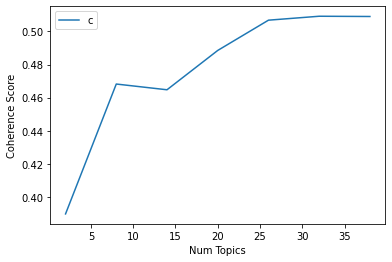

Num topics mallet = 2  has Coherence Value of  0.3897
Num topics mallet = 8  has Coherence Value of  0.4682
Num topics mallet = 14  has Coherence Value of  0.4647
Num topics mallet = 20  has Coherence Value of  0.4885
Num topics mallet = 26  has Coherence Value of  0.5068
Num topics mallet = 32  has Coherence Value of  0.5092
Num topics mallet = 38  has Coherence Value of  0.5091


In [29]:
# # for mallet model - peak number of topics is 31
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# #print coherence scores
for m,cv in zip(x, coherence_values):
    print("Num topics mallet =", m, " has Coherence Value of ", round(cv,4))

In [30]:
# #compute ideal number of topics for LDA/gensim model
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model = lda.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())
#     return model_list, coherence_values

In [31]:
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [32]:
# # #for gensim model - peak number of topics is 27
# limit=40; start=2; step=6;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence Score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [33]:
# #print coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics Gensim =", m, " has coherence value of ", round(cv,4))

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=dfList):
    #init output
    sent_topics_df = pd.DataFrame()
    
    #get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list  
        row = sorted(row, key=lambda x:(x[1]), reverse=True)
        #get dominant topic, perc contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_contribution', 'Topic_keywords']
    
    #add original text to the end
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

#format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_no', 'Dominant_topic', 'Topic_perc_contrib', 'Keywords', 'Text']

#show
#df_dominant_topic.head(10)

In [37]:
df_dominant_topic.Keywords.value_counts()

time, day, even, thing, well, much, really, year, still, good                                                2082
people, pain, chronic, life, many, other, way, disease, experience, person                                    398
doctor, treatment, patient, new, option, many, therapy, also, specialist, neurologist                         261
pain, headache, symptom, attack, diagnosis, severe, episodic, aura, brain, also                               250
study, patient, treatment, people, research, result, heart, clinical_trial, risk, survey                      176
community, headache, com, story, share, information, research, article, disease, video                        122
trigger, food, sleep, attack, diet, also, change, body, weather, hormone                                       62
medication, drug, side_effect, prescription, dose, abortive, pill, injection, month, caretaker                 24
health, child, insurance, care, state, service, program, condition, hospital, cost      

In [35]:
#output as csv
# df_dominant_topic.to_csv('LDA/posts_with_topics_lda.csv')

In [36]:
#get post_ID
# df_dominant_topic = pd.DataFrame(df_dominant_topic.Text.str.split("post_id:",1).tolist(), columns = ['post_text', 'post_id'])
# print(post_id)
# df_dominant_topic.Text[0]

In [37]:
#most representative doc for each topic
#group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_contribution'], ascending=[0]).head(1)], axis=0)

#reset index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

#format
sent_topics_sorteddf_mallet.columns = ['Topic_num', 'Topic_perc_contrib', 'keywords', 'text']

sent_topics_sorteddf_mallet

# sent_topics_sorteddf_mallet.to_csv('LDA/most_rep_post_lda.csv')

,Topic_num,Topic_perc_contrib,keywords,text
0,0.0,0.4808,"medication, drug, prescription, side_effect, t...",{'POST_CONTENT': 'Migraine treatments and medi...
1,1.0,0.2646,"recipe, cup, vegetable, cooking, dehydration, ...",{'POST_CONTENT': 'I received the inspiration f...
2,2.0,0.2688,"child, baby, kid, age, parent, young, old, adu...",{'POST_CONTENT': '<strong>Maternal Migraine an...
3,3.0,0.2809,"author, night, vote, pm, game, spring, music, ...","{'POST_CONTENT': 'It’s been <a href=""https://m..."
4,4.0,0.4798,"trigger, food, sleep, attack, many, change, di...",{'POST_CONTENT': 'Is food allergy testing a go...
5,5.0,0.3730,"exercise, body, stress, goal, task, energy, yo...",{'POST_CONTENT': 'Many individuals living with...
6,6.0,0.2103,"hair, holiday, thankful, autoimmune, birthday,...",{'POST_CONTENT': 'Tis the season for holiday c...
7,7.0,0.4453,"light, eye, room, glass, sunglass, bright, sun...",{'POST_CONTENT': 'Photophobia is a symptom man...
8,8.0,0.2435,"caregiver, travel, trip, injury, concussion, c...","{'POST_CONTENT': 'When <a href=""https://migrai..."
9,9.0,0.6406,"patient, doctor, treatment, new, specialist, h...","{'POST_CONTENT': 'Patients with <a href=""https..."


In [38]:
# pyLDAvis.enable_notebook()
# model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# vis=pyLDAvis.gensim.prepare(model, corpus, id2word)
# vis

In [39]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [41]:
import matplotlib.pyplot as plt
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(lda_model.show_topic(t, 200)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

AttributeError: 'list' object has no attribute 'items'

<Figure size 432x288 with 0 Axes>